# Gaussian density-split model vs. Gaussian mocks

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.interpolate import interp1d

from cosmoprimo import fiducial

from densitysplit.corr_func_utils import get_poles
from densitysplit.gaussian_model import *

# to automatically reload imported modules when executing cell
%load_ext autoreload
%autoreload 2

setup_logging()

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

plots_dir = '/feynman/home/dphp/mp270220/plots/densitysplit'

/feynman/work/dphp/adematti/cosmodesiconda/20240626-1.0.0/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Global parameters

In [2]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8
ells = [0]
nells = len(ells)

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## 2PCF model

In [3]:
basemodel = BaseTwoPointCorrelationFunctionModel(redshift=z, cosmology=cosmology, damping=True, b1=bias, boxsize=1000, nmesh=512)

[000000.08]  10-22 18:20  BaseTwoPointCorrelationFunctionModel INFO     Initializing BaseTwoPointCorrelationFunctionModel
[000000.08]  10-22 18:20  BaseTwoPointCorrelationFunctionModel INFO     Initializing theoretical 1D power spectrum
[000002.22]  10-22 18:20  BaseTwoPointCorrelationFunctionModel INFO     Applying damping from 80% of Nyquist frequency
[000002.22]  10-22 18:20  BaseTwoPointCorrelationFunctionModel INFO     Initializing ParticleMesh with boxisze 1000, nmesh 512
[000002.23]  10-22 18:20  BaseTwoPointCorrelationFunctionModel INFO     Painting 1D power spectrum on 3D mesh


/feynman/work/dphp/adematti/cosmodesiconda/20240626-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:532: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


[000133.32]  10-22 18:22  BaseTwoPointCorrelationFunctionModel INFO     3D power spectrum calculated in 131.09 seconds.


## $\xi(s)$

In [4]:
xi_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

xi_fn = '10gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar0.010_2PCF.npy'.format(z, bias, boxsize, nmesh)
xi = np.load(os.path.join(xi_dir, xi_fn), allow_pickle=True)
xi_ells, cov = get_poles(xi, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
s, _, _ = xi[0].get_corr(return_sep=True)

/feynman/work/dphp/adematti/cosmodesiconda/20240626-1.0.0/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


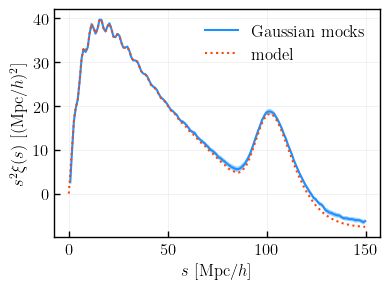

In [5]:
plt.rcParams["figure.figsize"] = (4, 3)

for ill, ell in enumerate(ells):
    y = s**2 * xi_ells[ill]
    error = s**2 * std[ill]

    plt.plot(s, y, label='Gaussian mocks')
    plt.fill_between(s, y-error, y+error, alpha=0.4)
    plt.plot(basemodel.sep, basemodel.sep**2 * basemodel.xi, label=r'model', ls=':')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig(os.path.join(plots_dir, 'gaussian_mocks_2PCF.pdf'), dpi=500)
plt.show()

## $\xi_{R}(s)$

In [6]:
smoothedmodel = SmoothedTwoPointCorrelationFunctionModel(basemodel, smoothing_scale=cellsize)

[000143.74]  10-22 18:22  BaseTwoPointCorrelationFunctionModel INFO     Initializing SmoothedTwoPointCorrelationFunctionModel
[000143.74]  10-22 18:22  BaseTwoPointCorrelationFunctionModel INFO     Setting smoothing scale to 10
[000143.74]  10-22 18:22  BaseTwoPointCorrelationFunctionModel INFO     Setting second smoothing scale to 10
[000143.74]  10-22 18:22  BaseTwoPointCorrelationFunctionModel INFO     Setting 3D smoothing kernel of order 6


/feynman/home/dphp/mp270220/densitysplit/densitysplit/base_model.py:146: RuntimeWarning: invalid value encountered in sqrt
  self.smoothed_sigma = np.sqrt(np.real(xiR))


[000173.24]  10-22 18:23  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to None


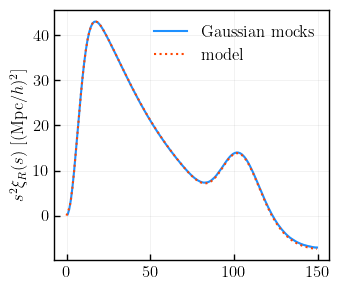

In [7]:
fig = plt.figure(figsize=(3.5, 3))

nb = 0.01

xiR = list()
for batch_index in range(10):
    xi_fn = '10gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_xi_R.npy'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler)
    batch_results = np.load(os.path.join(xi_dir, xi_fn), allow_pickle=True)
    for batch in batch_results:
        xiR.append(batch)

xiR_ells, cov = get_poles(xiR, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(len(xiR))
s, _, _ = xiR[0].get_corr(return_sep=True)

## Model
model_xiR = smoothedmodel.set_smoothed_xi(nbar=0)
model_xiR_shotnoise = smoothedmodel.set_smoothed_xi(nbar=nb)

for ill, ell in enumerate(ells):
    y = s**2 * xiR_ells[ill]
    error = s**2 * std[ill]

    plt.plot(s, y, label='Gaussian mocks')
    plt.fill_between(s, y-error, y+error, alpha=0.4)
    #axes[0].plot(smoothedmodel.sep, smoothedmodel.sep**2 * model_xiR, label=r'model without shot noise', ls=':')
    plt.plot(smoothedmodel.sep, smoothedmodel.sep**2 * model_xiR_shotnoise, label=r'model', ls=':', color='C1')
    
    #model_interp = interp1d(smoothedmodel.sep.transpose()[0], model_xiR_shotnoise.transpose()[0])
    #y_err = s**2 * (model_interp(s) - xiR_ells[ill])
    #axes[1].plot(s, y_err/error) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    #axes[1].fill_between(s, y_err-error, y_err+error, alpha=0.4)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylabel(r'$s^2 \Delta \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylabel(r'$\Delta \xi_{R}(s) / \sigma$')
fig.align_ylabels()
plt.legend()
plt.savefig(os.path.join(plots_dir, 'gaussian_mocks_xiR_nbar{}.pdf'.format(nb)), dpi=500)
plt.show()

## $\delta_R$

In [8]:
smootheddensitymodel = SmoothedGaussianDensityModel(smoothedmodel)

[000253.76]  10-22 18:24  BaseTwoPointCorrelationFunctionModel INFO     Initializing SmoothedGaussianDensityModel


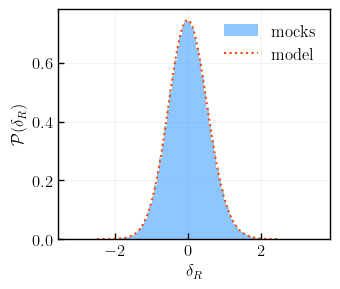

In [22]:
mocks_dir = '/feynman/scratch/dphp/mp270220/mocks/gaussian/'
delta_fn = '{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{{:.3f}}_cellsize{:d}_resampler{}_delta_R.npy'.format(10, z, bias, boxsize, nmesh, cellsize, resampler)

delta = np.linspace(-2.5, 2.5, 100)

fig = plt.figure(figsize=(3.5, 3))

## Mocks
densities = np.load(os.path.join(mocks_dir, delta_fn.format(nb)))

## Model
model_density = scipy.stats.norm.pdf(delta, 0, smootheddensitymodel.double_smoothed_sigma)
model_density_gaussianshotnoise = smootheddensitymodel.density(delta, p=2, nbar=nb)
model_density_fullshotnoise = smootheddensitymodel.density(delta, p=4, nbar=nb)

plt.hist(np.ravel(densities), bins=100, density=True, alpha=0.5, label='mocks')
#plt.plot(delta, model_density, label='No shot noise', ls=':', color='orangered')
#plt.plot(delta, model_density_gaussianshotnoise, label='Gaussian shot noise', ls='--', color='darkcyan')
plt.plot(delta, model_density_fullshotnoise, label='model', ls=':', color='orangered')
plt.xlabel(r'$\delta_R$')    
plt.ylabel(r'$\mathcal{P}(\delta_R)$')    
plt.legend()
plt.savefig(os.path.join(plots_dir, 'gaussian_mocks_deltaR_nbar{}.pdf'.format(nb)), dpi=500)
plt.show()

## $\xi_R^{DS}$ (randoms - tracers)

In [14]:
nsplits = 3
randoms_size = 4
density_bins = np.array([-np.inf, -0.21875857,  0.21875857, np.inf])

In [12]:
smootheddensitysplitsmodel = GaussianDensitySplitsModel(smootheddensitymodel, nsplits=nsplits, randoms_size=randoms_size, density_bins=density_bins)

[000394.24]  10-22 18:26  BaseTwoPointCorrelationFunctionModel INFO     Initializing GaussianDensitySplitsModel with 3 density splits


[001948.43]  10-22 18:52  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0
[001966.12]  10-22 18:53  BaseTwoPointCorrelationFunctionModel INFO     nbar is 0, density is Gaussian.
[001966.12]  10-22 18:53  BaseTwoPointCorrelationFunctionModel INFO     Computing cross-correlation of density-split randoms and all tracers with 3 density splits, nbar = 0, and Edgeworth expansion of order 0.
[002000.72]  10-22 18:53  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0.01
[002035.13]  10-22 18:54  BaseTwoPointCorrelationFunctionModel INFO     Computing moments of the smoothed density contrast.
[002044.19]  10-22 18:54  BaseTwoPointCorrelationFunctionModel INFO     1st order moment: 0.9999999999999984.
[002045.52]  10-22 18:54  BaseTwoPointCorrelationFunctionModel INFO     2nd order moment: 1.294053703217899.
[002054.14]  10-22 18:54  BaseTwoPointCorrelationFunctionModel INFO     3rd order moment: 1.8948052883207023.
[002103.41]  10-22 18:55  BaseTwoPointCorrelationF

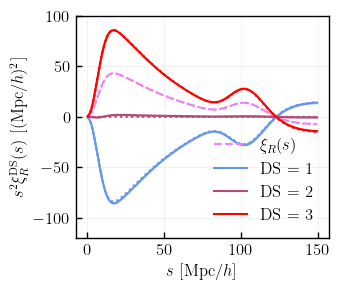

In [21]:
fig = plt.figure(figsize=(3.5, 3))

from matplotlib.colors import LinearSegmentedColormap

base_colors = ['cornflowerblue', 'red']
cmap = LinearSegmentedColormap.from_list("mycmap", base_colors, N=nsplits)
colors = [cmap(i) for i in range(nsplits)]

model_ccf = smootheddensitysplitsmodel.ccf_randoms_tracers(nbar=0, p=0)
model_xiR_shotnoise = smoothedmodel.set_smoothed_xi(nbar=nb)

xiR = list()
for batch_index in range(10):
    xi_fn = '10gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
    batch_results = np.load(xi_dir+xi_fn+'_RH_CCF.npy', allow_pickle=True)
    for batch in batch_results:
        xiR.append(batch)

## Mocks
mocks_split_xi_rh, cov_rh = get_split_poles(xiR, ells=ells)
std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(len(xiR))
s, _, _ = xiR[0][0].get_corr(return_sep=True)

## Model
model_ccf_gaussian_shotnoise = smootheddensitysplitsmodel.ccf_randoms_tracers(nbar=nb, p=2)
model_ccf_full_shotnoise = smootheddensitysplitsmodel.ccf_randoms_tracers(nbar=nb, p=4)

for ill, ell in enumerate(ells):
    plt.plot(s, s**2 * xiR_ells[ill], label=r'$\xi_{R}(s)$', color='violet', ls='--')
    plt.plot(smootheddensitysplitsmodel.sep, smootheddensitysplitsmodel.sep**2 * model_xiR_shotnoise, color='violet', ls=':')
    
    for ds in range(nsplits):
        y = s**2 * mocks_split_xi_rh[ds][ill]
        error = s**2 * std_rh[ds][ill]

        plt.plot(s, y, color=colors[ds])
        plt.fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
        plt.plot(smootheddensitysplitsmodel.sep, smootheddensitysplitsmodel.sep**2 * model_ccf_full_shotnoise[ds], ls=':', color=colors[ds])
        
for ds in range(nsplits):
    plt.plot([], [], label=r'DS = {}'.format(ds+1), color=colors[ds])
#plt.plot([], [], ls='-', color='black', label='Gaussian mocks')
#plt.plot([], [], ls='--', color='black', label='Gaussian model')
plt.legend()
plt.ylim(-120, 100)
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}^{\rm DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'gaussianModelvsMocks_densitysplits_nbar{}.pdf'.format(nb)), dpi=500)
plt.show()

[001764.10]  06-24 18:33  BaseTwoPointCorrelationFunctionModel INFO     Computing cross-correlation of density-split randoms and all tracers with 3 density splits, nbar = 0.01, and Edgeworth expansion of order 4.
[001764.10]  06-24 18:33  BaseTwoPointCorrelationFunctionModel INFO     Computing delta tilde.


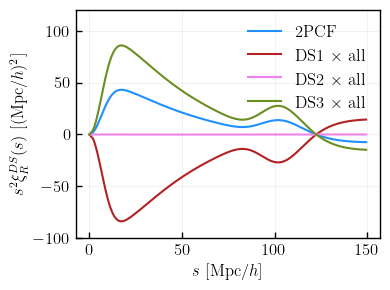

In [19]:
plt.rcParams["figure.figsize"] = (6, 5)

plt.figure(figsize=(4, 3))

i=1
nb=0.01

## Model
model_xiR_shotnoise = smoothedmodel.set_smoothed_xi(nbar=nb)
model_ccf_full_shotnoise = smootheddensitysplitsmodel.ccf_randoms_tracers(nbar=nb, p=4)
 
for ill, ell in enumerate(ells):
    plt.plot(smootheddensitysplitsmodel.sep, smootheddensitysplitsmodel.sep**2 * model_xiR_shotnoise, color='C0', label='2PCF')
    for ds in range(nsplits):
        plt.plot(smootheddensitysplitsmodel.sep, smootheddensitysplitsmodel.sep**2 * model_ccf_full_shotnoise[ds], color=colors[ds], label=r'DS{} $\times$ all'.format(ds+1))
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend(loc='upper right')
plt.ylim(-100, 120)
plt.savefig(os.path.join(plots_dir, 'gaussianModel_densitysplits_smoothed2PCF.pdf'), dpi=500)
plt.show()